# Entrenamiento de red neuronal densamente conectada para la detección de dígitos decimales

En este trabajo se entrenará una red neuronal para detectar dígitos decimales utilizando la base de datos de MNIST.

A lo largo de este trabajo me apoyé en IA generativa para realizar gráficas, y acelerar escritura de código. en cada una de esas celdas se hace esa referencia

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
print(f"{tf.__version__}")
import cv2
print(f"{cv2.__version__}")

2.18.0
4.11.0


## Exploración de datos

Primero importamos los datos

In [2]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Deberían ser 70000 imágenes en total, siendo 60000 para train y 10000 para test.

In [ ]:
### IA
# Print the shapes of the datasets
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


podemos observar que no solamente el número de imágenes es correcto, también vemos que el tamaño de las imágenes es de 28x28. Ahora que comprobamos que los datos se importaron correctamente, examinemos ejemplos de imágenes de la base de datos para visualizar con qué estamos trabajando

Class Proportions:
Label 0: 0.0987
Label 1: 0.1124
Label 2: 0.0993
Label 3: 0.1022
Label 4: 0.0974
Label 5: 0.0903
Label 6: 0.0986
Label 7: 0.1044
Label 8: 0.0975
Label 9: 0.0992


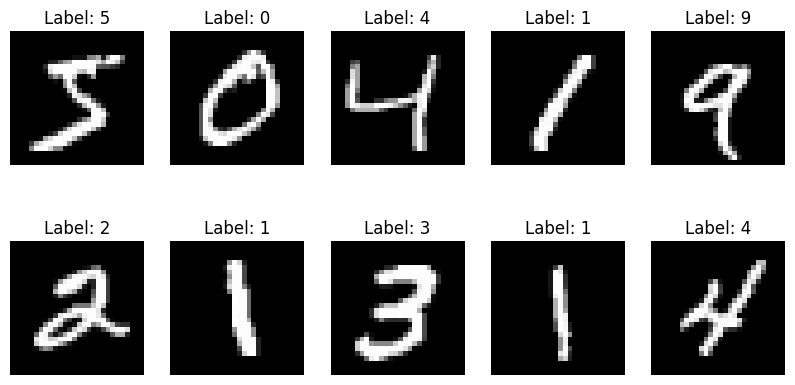


Pixel Value Range: 0 - 255


In [ ]:
### IA
# 1. Check Class Proportions:
unique_labels, counts = np.unique(train_labels, return_counts=True)
class_proportions = dict(zip(unique_labels, counts / len(train_labels)))

print("Class Proportions:")
for label, proportion in class_proportions.items():
    print(f"Label {label}: {proportion:.4f}")

# 2. Display Example Images:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

# 3. Check Pixel Value Range:
print(f"\nPixel Value Range: {train_images.min()} - {train_images.max()}")

Podemos observar que trabajamos con imágenes en escala de grises, donde cada pixel tiene valores de 0 a 255, y las imágenes son números blancos con fondo negro. Esto será importante a la hora de procesar imágenes que no encajen con esta descripción, pero que querramos usar para que el modelo haga predicciones en el futuro

## Entrenamiento de modelo

Ahora empezaremos a entrenar el modelo. Se usará una red neuronal densamente conectada con 5 capas. Una para hacer un resize a la imagen de entrada del modelo al tamaño de imágenes de entrenamiento, 2 capas ocultas con activación relu, 1 capa oculta de dropout (para reducir overfitting), y la última capa que es para predicción. Como estamos trabajando con un sistema que hará predicciones para 10 clases, se usará una capa con activación softmax de 10 neuronas.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

### PRIMER EXPERIMENTO - CORTESIA DE OPEN AI
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(73, activation='relu'))
model.add(Dropout(0.2))                # ayuda a reducir overfitting
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 73)             │         9,417 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 73)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           740 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,637 (432.18 KB)

 Trainable params: 110,637 (432.18 KB)

 Non-trainable params: 0 (0.00 B)

'history = model.fit(\n    train_images, train_labels,\n    validation_data=(test_images, test_labels),\n    epochs=5,\n    batch_size=32\n)'

No queremos que se entrene infinitamente si no hay mejoras significativas. Por eso usaremos un `early stopping`. Además, le permitiremos que se entrene durante 5 épocas (el entrenamiento puede durar mucho dependiendo de los hiperparámetros, así que de momento empezaré con 5), con un batch_size de un tamaño de potencia de 2 (en este caso, $2^5 = 32$)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

### IA
# da igual si es val_loss o val_accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6258 - loss: 4.5640 - val_accuracy: 0.8690 - val_loss: 0.5888
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8321 - loss: 0.6449 - val_accuracy: 0.9098 - val_loss: 0.3965
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8864 - loss: 0.4479 - val_accuracy: 0.9357 - val_loss: 0.3461
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9065 - loss: 0.3591 - val_accuracy: 0.9515 - val_loss: 0.2249
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9276 - loss: 0.2651 - val_accuracy: 0.9543 - val_loss: 0.2330


Ahora que terminamos de entrenar el modelo, veamos cómo fue variando su precisión a lo largo de las etapas de entrenamiento y validación cruzada (CV)

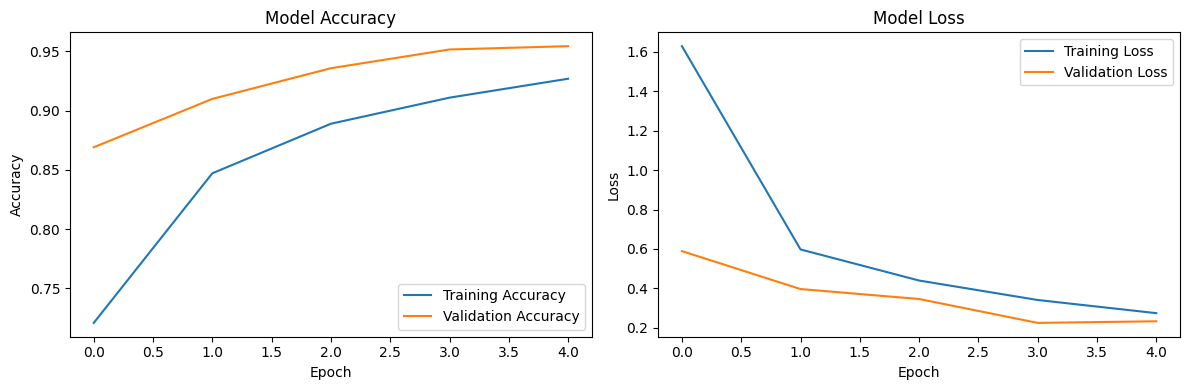

In [ ]:
### IA
# Visualize training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Evaluación en dataset de prueba

Ahora comparemos exactitudes entre CV y dataset de prueba. Si son muy distintas, probablemente haya algo extraño

In [1]:
from tensorflow.keras.models import load_model
modelo1 = load_model("modelo1.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
### IA
loss, accuracy = modelo1.evaluate(test_images, test_labels, verbose=0)

val_accuracy = 0.95625 #aproximadamente la ultima acc de cv. no queria entrenar todo de nuevo
print(f"Exactitud en el conjunto de prueba: {accuracy}")
print(f"Exactitud de validación: {val_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Exactitud en el conjunto de prueba: 0.9514999985694885
Exactitud de validación: 0.95625


La diferencia es de 5 milésimas. Es bueno porque al ser similares se puede ver que no se sobre ajustó el modelo.

## Evaluación de modelo con dataset propio

Ahora evaluaré la precisión de mi modelo con un conjunto de prueba hecho por mí. La idea es hacer números con marcador negro, tomarles fotos (con ligeras variaciones), y mostrárselas al modelo. Pero para ello necesito convertir las imágenes de entradas al formato de las de entrenamiento.

Para convertir cualquier imagen de entrada (una imagen "normal", en formato RGB) a las de entrenamiento se usará una función para hacer el pre procesamiento.

In [7]:
import cv2

### IA
def preProcesarImagen(nombreArchivo):
  """
  Preprocesa una imagen para su uso en una red neuronal.

  Args:
      nombreArchivo: El nombre del archivo de la imagen.

  Returns:
      Una imagen preprocesada como un array NumPy.
  """
  # 1. Leer la imagen en escala de grises
  imagen = cv2.imread(nombreArchivo, cv2.IMREAD_GRAYSCALE)

  # 2. Binarización por umbral (experimental o con Otsu)
  _, imagenBinarizada = cv2.threshold(imagen, 80, 255, cv2.THRESH_BINARY)  # Umbral experimental = 127
  # Alternativa con Otsu:
  # _, imagenBinarizada = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # 3. Invertir colores BYN
  imagenBinarizada = cv2.bitwise_not(imagenBinarizada)

  # 4. Reescalar a 28x28
  imagenReescalada = cv2.resize(imagenBinarizada, (28, 28))

  return imagenBinarizada, imagenReescalada

Para la creación de un dataset propio estilo MINST, tuve que hacer numeros en papel con un marcador. Luego me di cuenta que estaban rotados (puse mi celular en vertical, pero se tomaron como si hubiera estado en horizontal), entonces me apoyé de IA para hacer un script en python que las rotara adecuadamente. Después las agregué a este ambiente de trabajo y las pasé a una lista de Python

In [8]:
fotosRotadas = []
for i in range(2,52,1):#siguen siendo 50 imagenes. la primera esta numerada como #2 y la ultima como #51
  if i < 10:
    fotosRotadas.append(f"rotada_IMG-20250427-WA000{i}.jpg")
  else:
    fotosRotadas.append(f"rotada_IMG-20250427-WA00{i}.jpg")

# las labels las puse manual porque no se ingresaron las fotos en orden
# descendente según los números a los que se les tomó foto
myLabels = [9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 8,
            7, 7, 6, 6, 6, 5, 5, 7, 7, 5, 5,
            6, 6, 4, 4, 4, 4, 4, 5, 3, 3, 3,
            3, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1,
            1, 0, 0, 0, 0, 0]

myLabels = np.array(myLabels) #para ingresarse en sampleModel.evaluate()

fotosProcesadas = []
for nombre in fotosRotadas:
  fotosProcesadas.append(preProcesarImagen(nombre)[1])

Visualizamos las imágenes como se hizo anteriormente (pueden mostrarse imágenes repetidas, pero ninguna imagen dentro de la base de datos está repetida)

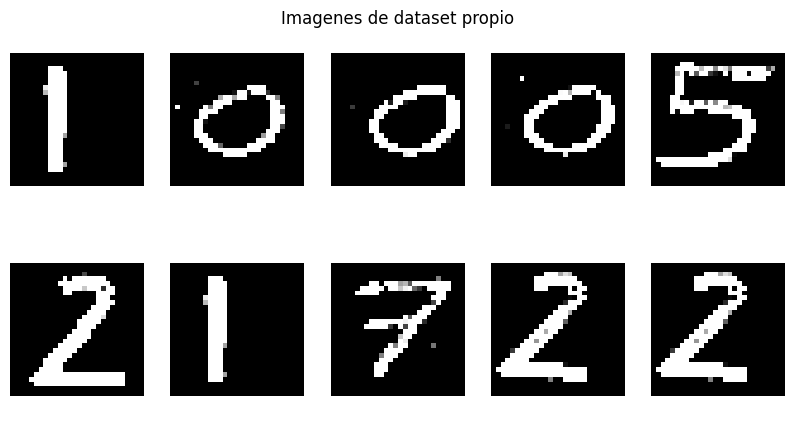

In [ ]:
### IA
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title("Imagenes de dataset propio")
plt.axis('off')
sampleIndeces = np.random.randint(0, len(fotosProcesadas), 10)
sampleImages = [fotosProcesadas[i] for i in sampleIndeces]
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sampleImages[i], cmap='gray')
    plt.axis('off')
plt.show()

Evaluamos similarmente al primer conjunto de prueba

In [ ]:
### IA

fotosssss = np.array(fotosProcesadas)
myLoss, myAccuracy = modelo1.evaluate(fotosssss, myLabels, verbose=0)

print(f"Exactitud en mi conjunto (de prueba): {myAccuracy}")

Exactitud en mi conjunto (de prueba): 0.3199999928474426


Aquí se puede apreciar la diferencia de accuracy entre la prueba con la base de datos MINST con mis números. Dado que no es una RNC, hay algunas características en las imágenes que pueden hacer pensar al modelo que debe tomar alguna decisión en particular. Si hay algun punto blanco fuera del numero, si no esta bien dibujado, su posición con respecto al centro de la imagen, si está inclinado o no el numero, etc.

## Segundo modelo

Para el segundo modelo haré unas modificaciones al primer modelo. Le agregaré:
- otra capa oculta a la red neuronal para que tenga oportunidad de aprender otras features que le ayude a identificar números
- un learning rate de 0.0005, en lugar de 0.001, para que tenga mayor precisión (aun si se tarda un poco más en entrenar)
- más épocas de entrenamiento. Pasaré de 5 épocas a 20, para igual buscar mayor precisión

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

modelo2 = Sequential()
modelo2.add(Flatten(input_shape=(28, 28)))
modelo2.add(Dense(128, activation='relu'))
modelo2.add(Dense(128, activation='relu')) #otra capa oculta. explorar features
modelo2.add(Dense(73, activation='relu'))
modelo2.add(Dropout(0.2))
modelo2.add(Dense(10, activation='softmax'))

modelo2.compile(
    optimizer=Adam(learning_rate=0.0005), #cambiar learning rate. de 0.001 a 0.0005
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

modelo2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 73)             │         9,417 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           740 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,149 (496.68 KB)

 Trainable params: 127,149 (496.68 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
### IA
# da igual si es val_loss o val_accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = modelo2.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=20, #aumentar epocas. de 5 a 20
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6417 - loss: 4.1824 - val_accuracy: 0.9068 - val_loss: 0.3681
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8816 - loss: 0.4279 - val_accuracy: 0.9351 - val_loss: 0.2532
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9175 - loss: 0.2882 - val_accuracy: 0.9463 - val_loss: 0.2263
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9373 - loss: 0.2209 - val_accuracy: 0.9570 - val_loss: 0.1695
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9504 - loss: 0.1732 - val_accuracy: 0.9618 - val_loss: 0.1568
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9560 - loss: 0.1493 - val_accuracy: 0.9627 - val_loss: 0.1589
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9646 - loss: 0.1238 - val_accuracy: 0.9601 - val_loss: 0.1583
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9668 - loss: 0.1117

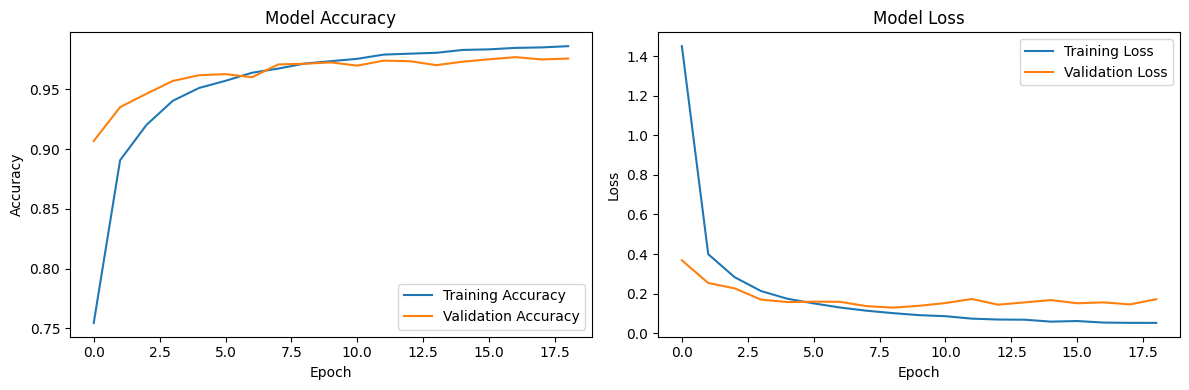

In [4]:
### IA
# Visualize training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [6]:
### IA
loss2, accuracy2 = modelo2.evaluate(test_images, test_labels, verbose=0)
val_accuracy2 = history2.history['val_accuracy'][-1]

print(f"Exactitud en el conjunto de prueba: {accuracy2}")
print(f"Exactitud de validación: {val_accuracy2}")

Exactitud en el conjunto de prueba: 0.9714000225067139
Exactitud de validación: 0.9757000207901001


In [10]:
fotosssss2 = np.array(fotosProcesadas)
myLoss2, myAccuracy2 = modelo2.evaluate(fotosssss2, myLabels, verbose=0)

print(f"Exactitud en mi conjunto (de prueba): {myAccuracy2}")

Exactitud en mi conjunto (de prueba): 0.36000001430511475


Tal parece que comparando con el dataset de prueba MINST como con mi dataset hubo mejoría en la precisión del modelo con estos ajustes. Pasó de 0.95 a 0.97 (redondeando) en el de MINST, y de 0.32 a 0.36 en el mío. Además, fueron similares la accuracy en CV como en test, entonces no hubo sobreajuste, lo cual también es bueno.

In [13]:
modelo2.save('modelo2.h5')

Ahora con este modelo se usó un script de python para generar un sistema que prediga en tiempo real los dígitos del 0 al 9 a partir de la imagen capturada por la cámara de mi laptop.

In [ ]:
import cv2
import numpy as np
from tensorflow import keras

""""

fue un SHOW intentar correr esto local por las dependencias.
quise instalar con conda dentro de un venv de conda pero no jalo.
eventualmente tuve que instalar todo con pip. primero upgrade tf con pip,
luego reinstale numpy con pip, luego opencv, luego hd5f o h5py,
no recuerdo con cual de esas dos jalo (o si con las dos). NO RECOMIENDO.
A la otra busquen usar pip desde el inicio, aun dentro de un venv de conda
para cuando quieran usar tensorflow y keras. ASH, qué asco.

Ya vi. lo ultimo que instalé fue opencv.

"""

# Cargar el modelo
model = keras.models.load_model('tu_ruta') #cambié el path original

# Función para preprocesar la imagen
def preProcesarImagen(imagen):
    imagenGris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    _, imagenBinarizada = cv2.threshold(imagenGris, 80, 255, cv2.THRESH_BINARY)
    imagenBinarizada = cv2.bitwise_not(imagenBinarizada)
    imagenReescalada = cv2.resize(imagenBinarizada, (28, 28))
    return imagenReescalada

# Inicializar la cámara
cap = cv2.VideoCapture(0)

while True:
    # Capturar un frame de la cámara
    ret, frame = cap.read()

    # Preprocesar la imagen
    imagenPreprocesada = preProcesarImagen(frame)

    # Realizar la predicción
    prediccion = model.predict(imagenPreprocesada.reshape(1, 28, 28))
    label = np.argmax(prediccion)

    # Mostrar el resultado en la imagen
    cv2.putText(frame, str(label), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Mostrar la imagen
    cv2.imshow('Predicción de dígitos', frame)

    # Salir si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()

## Resultados de programa en tiempo real

Como se podrá apreciar en las imágenes de abajo, el modelo pudo detectar correctamente algunos de los números que le mostraba:

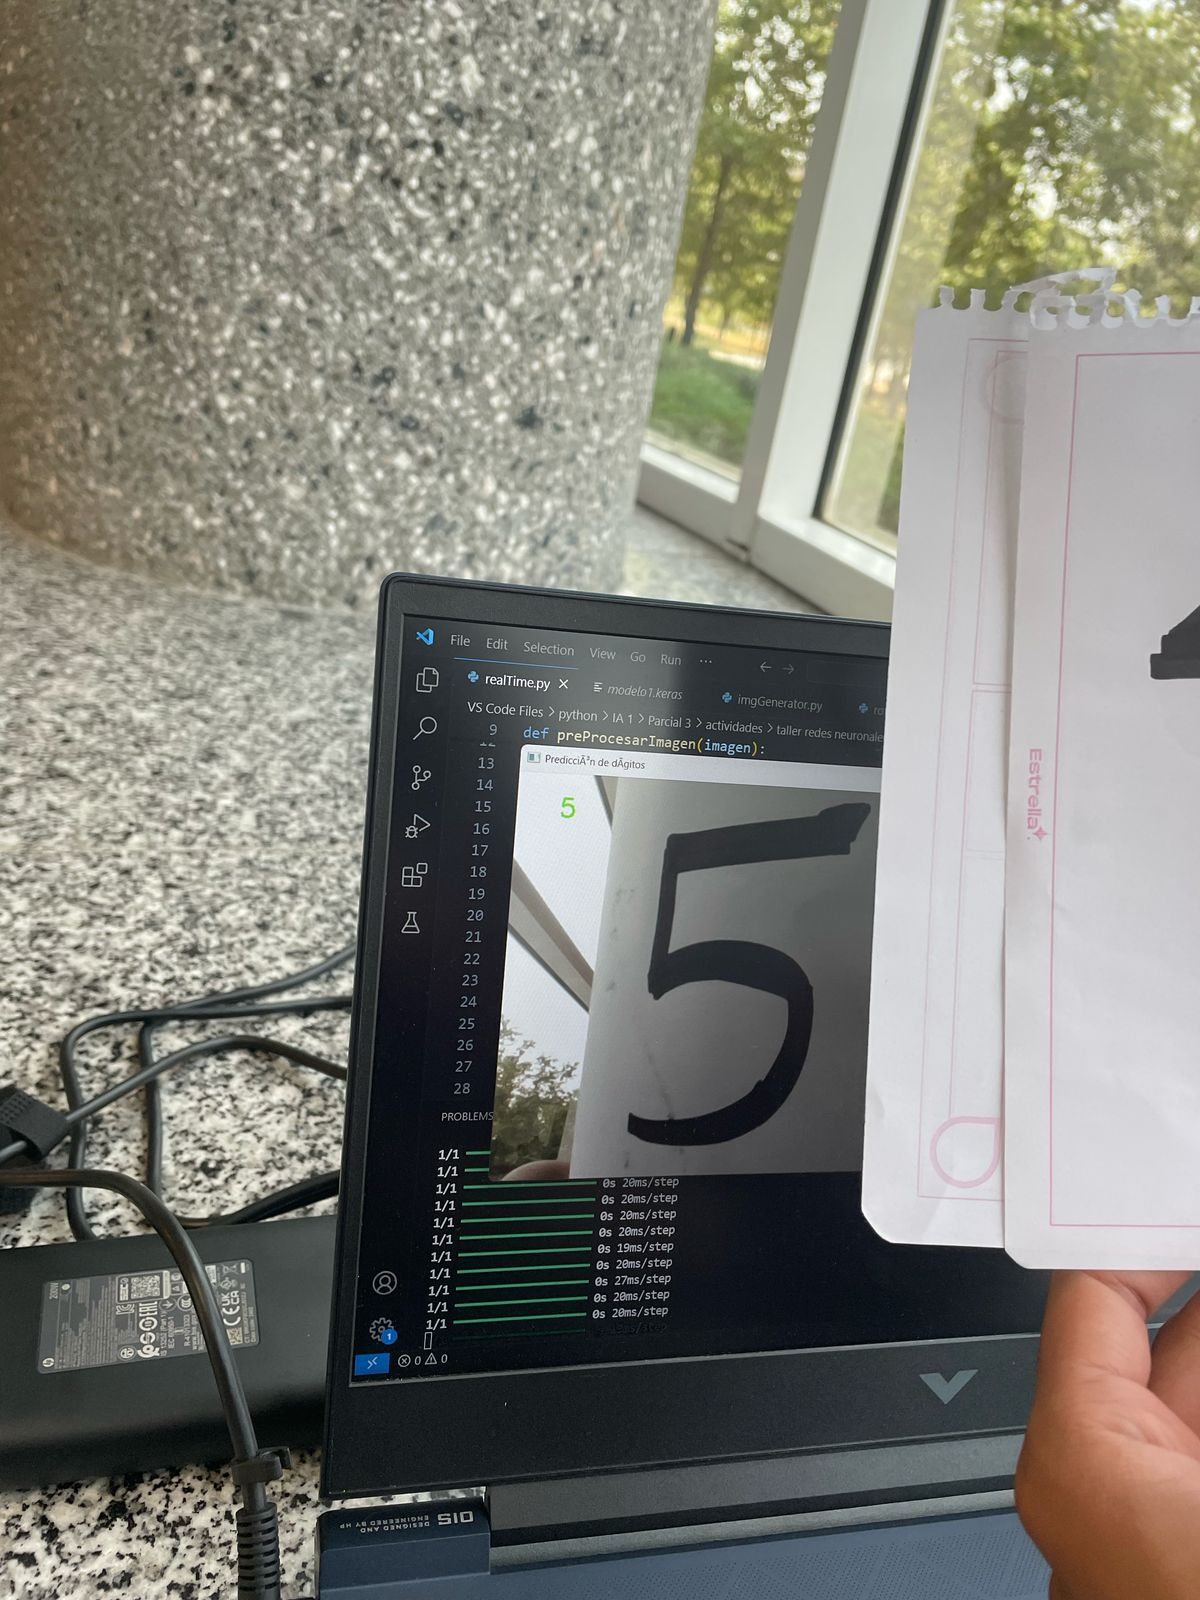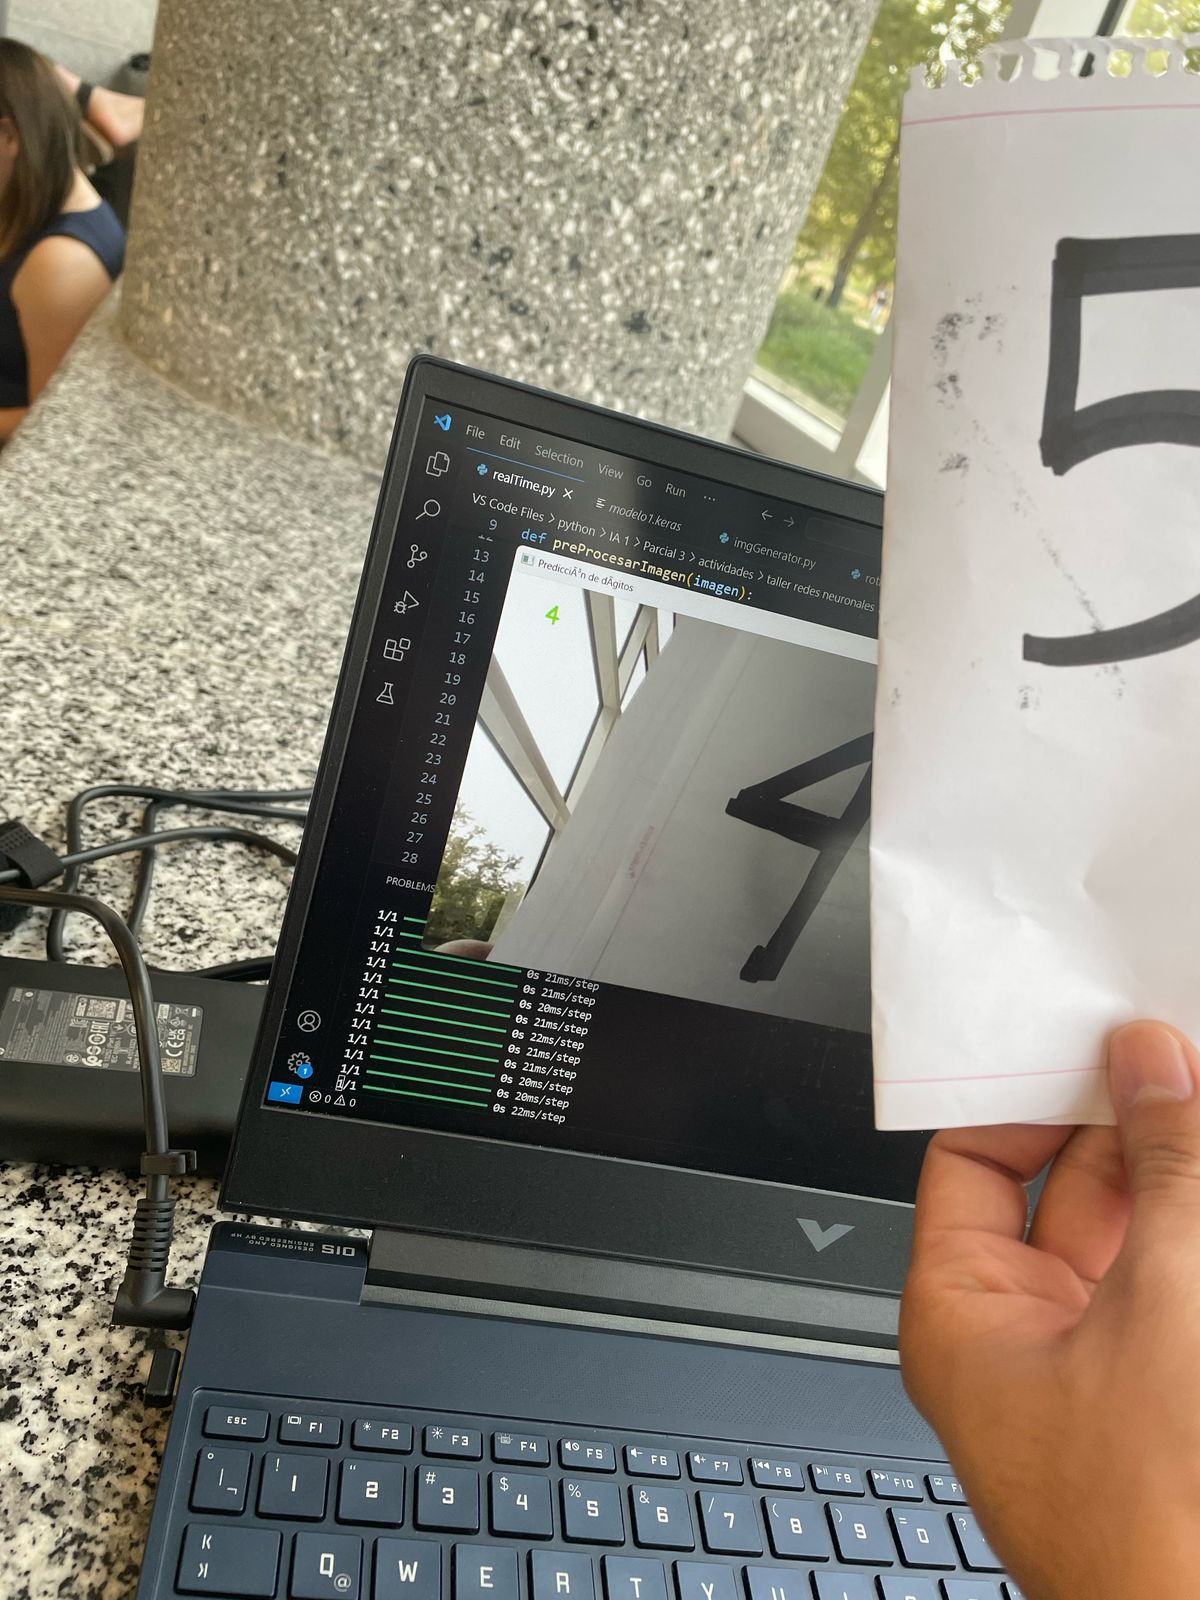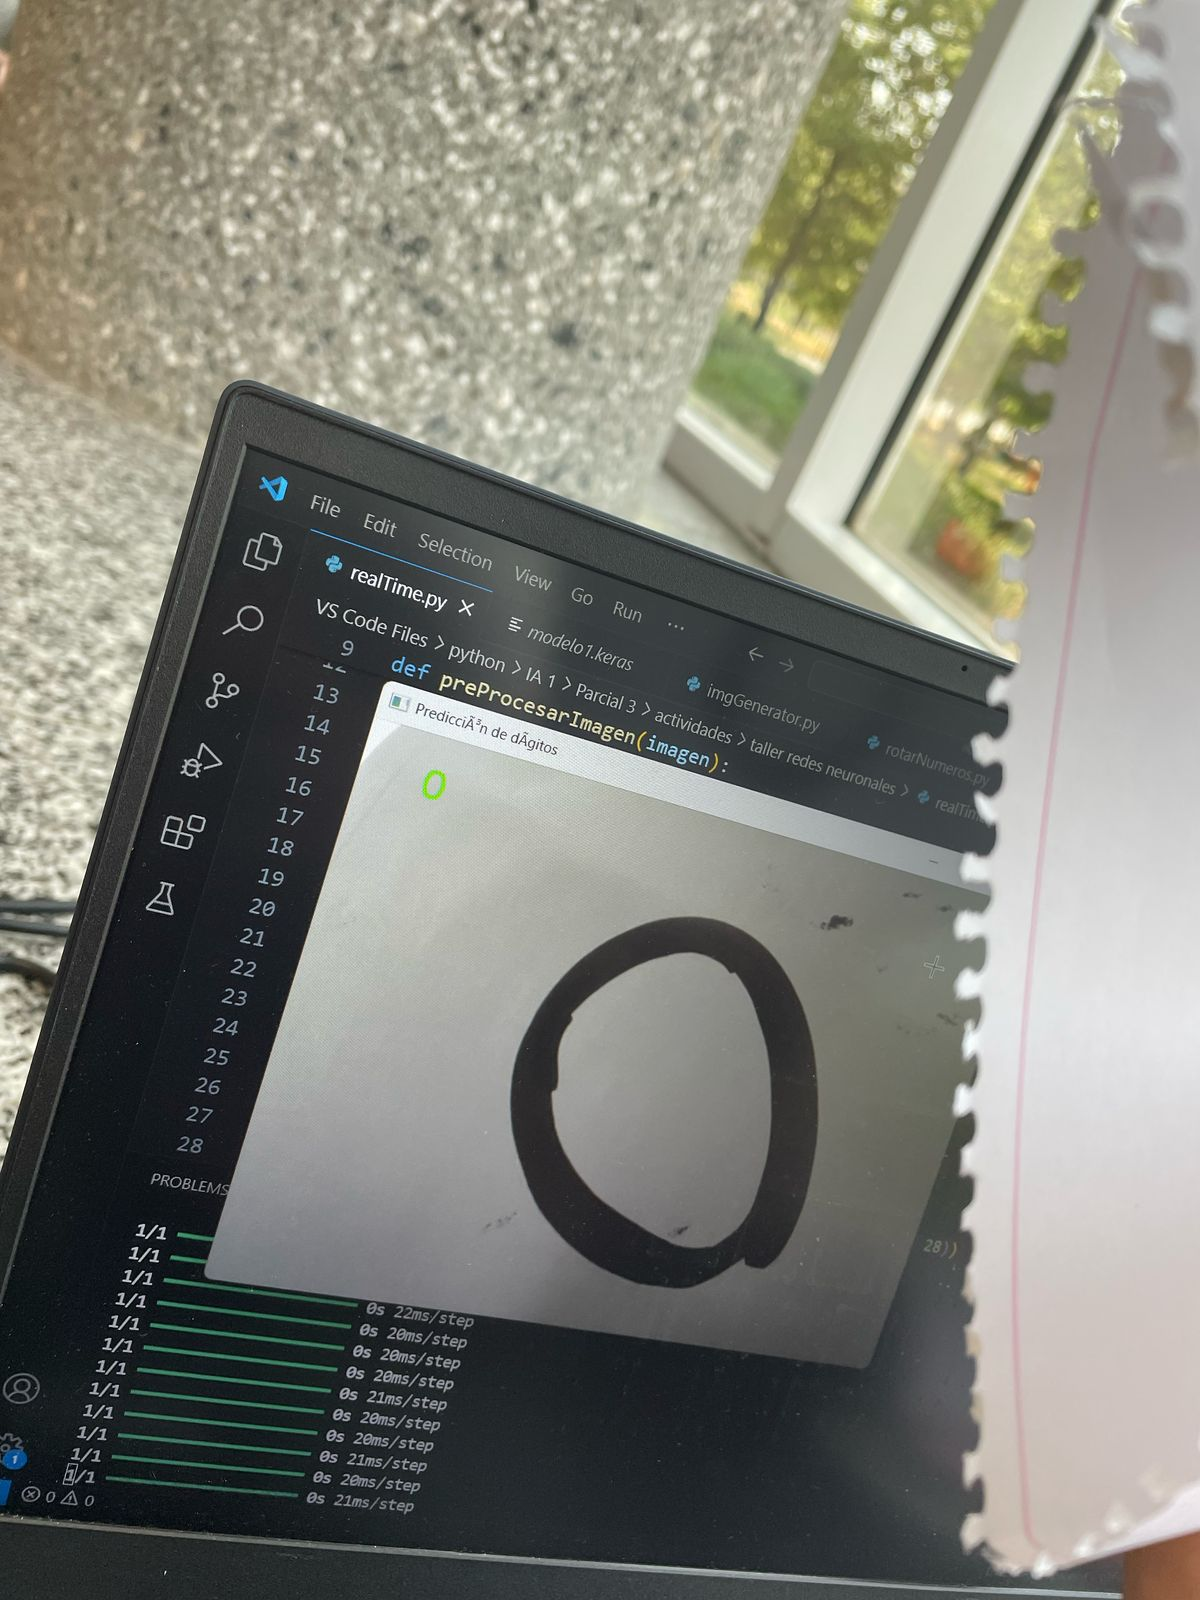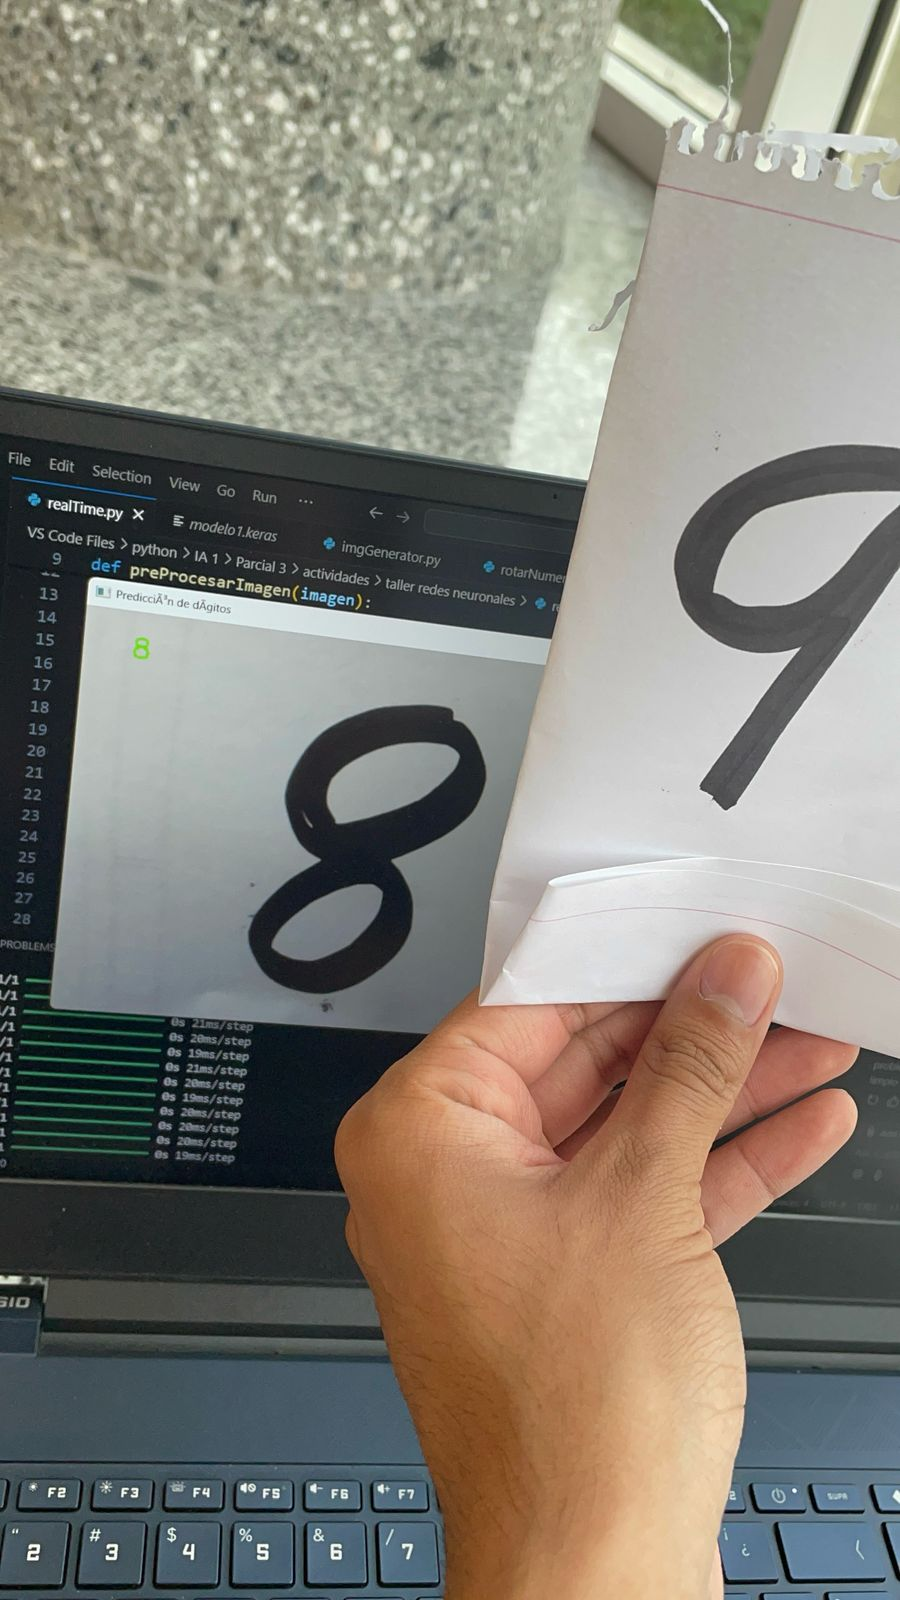

Sin embargo, hubieron otras en las que batallaba. Unos números no los detectaba realmente, y otros números variaba mucho la posición en la que fueran presentados. He aquí unos ejemplos:

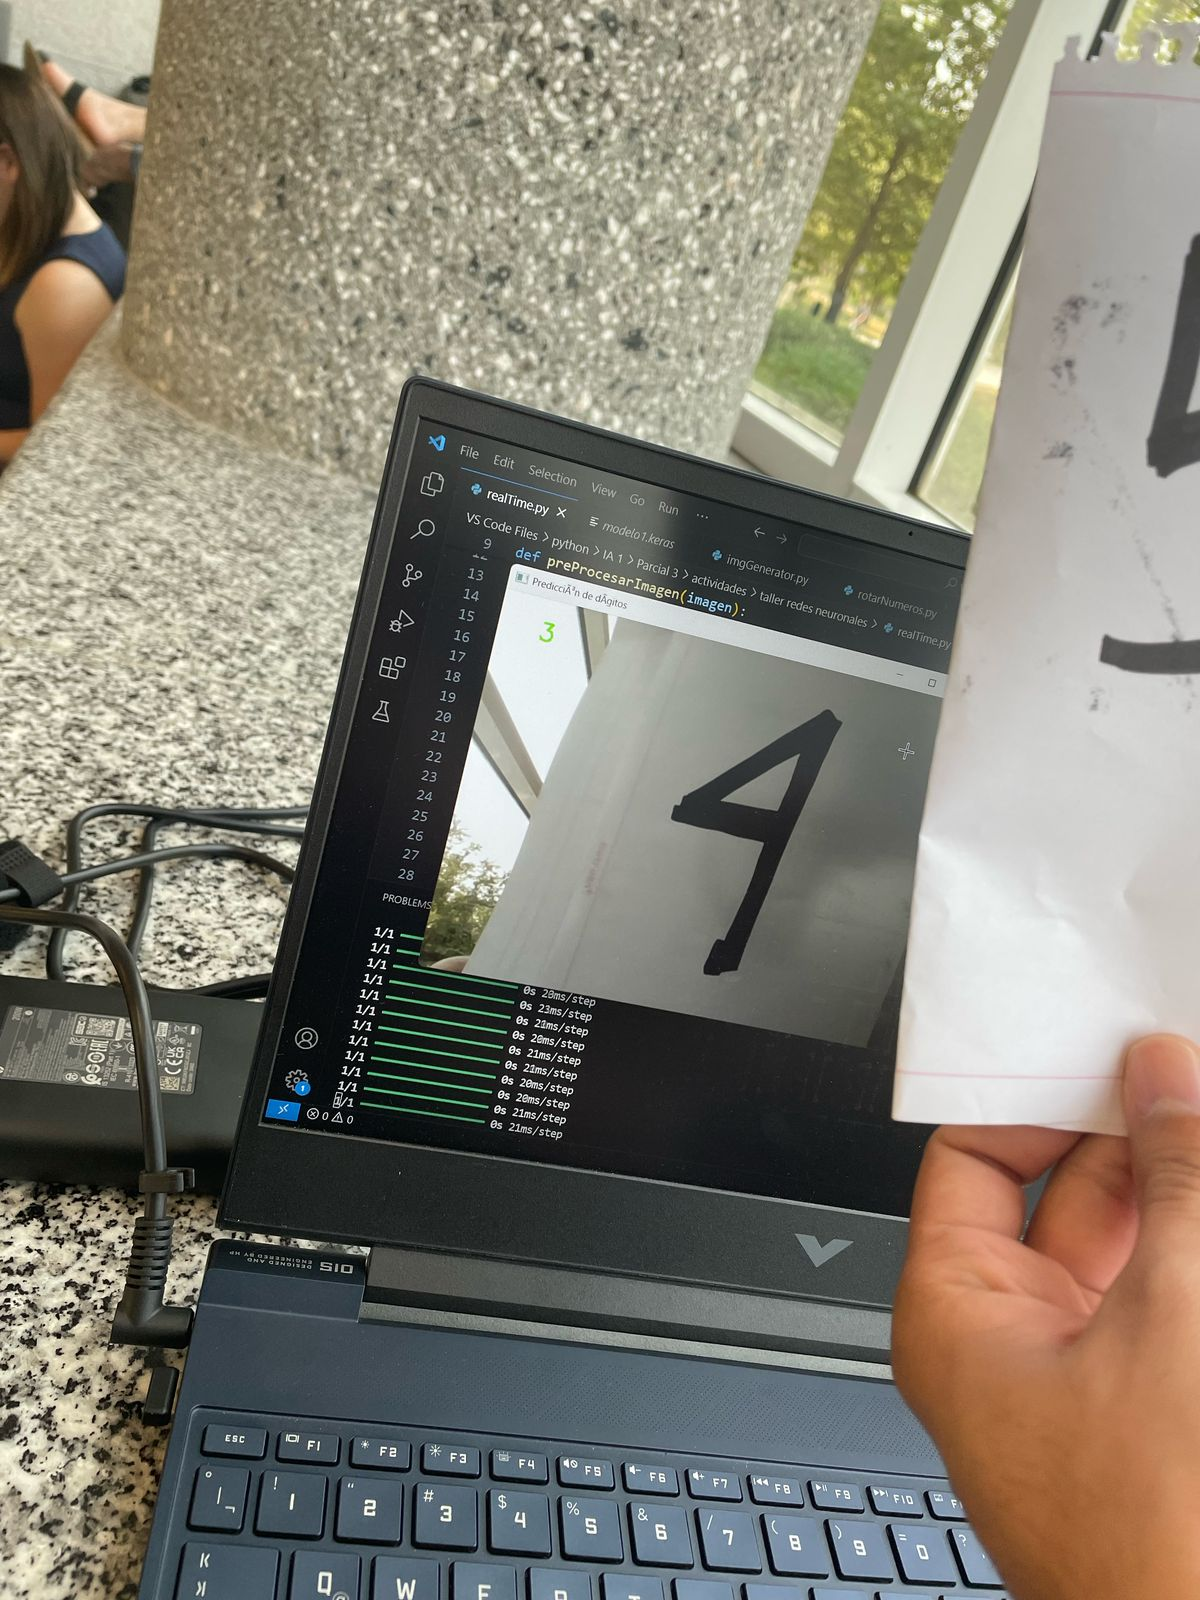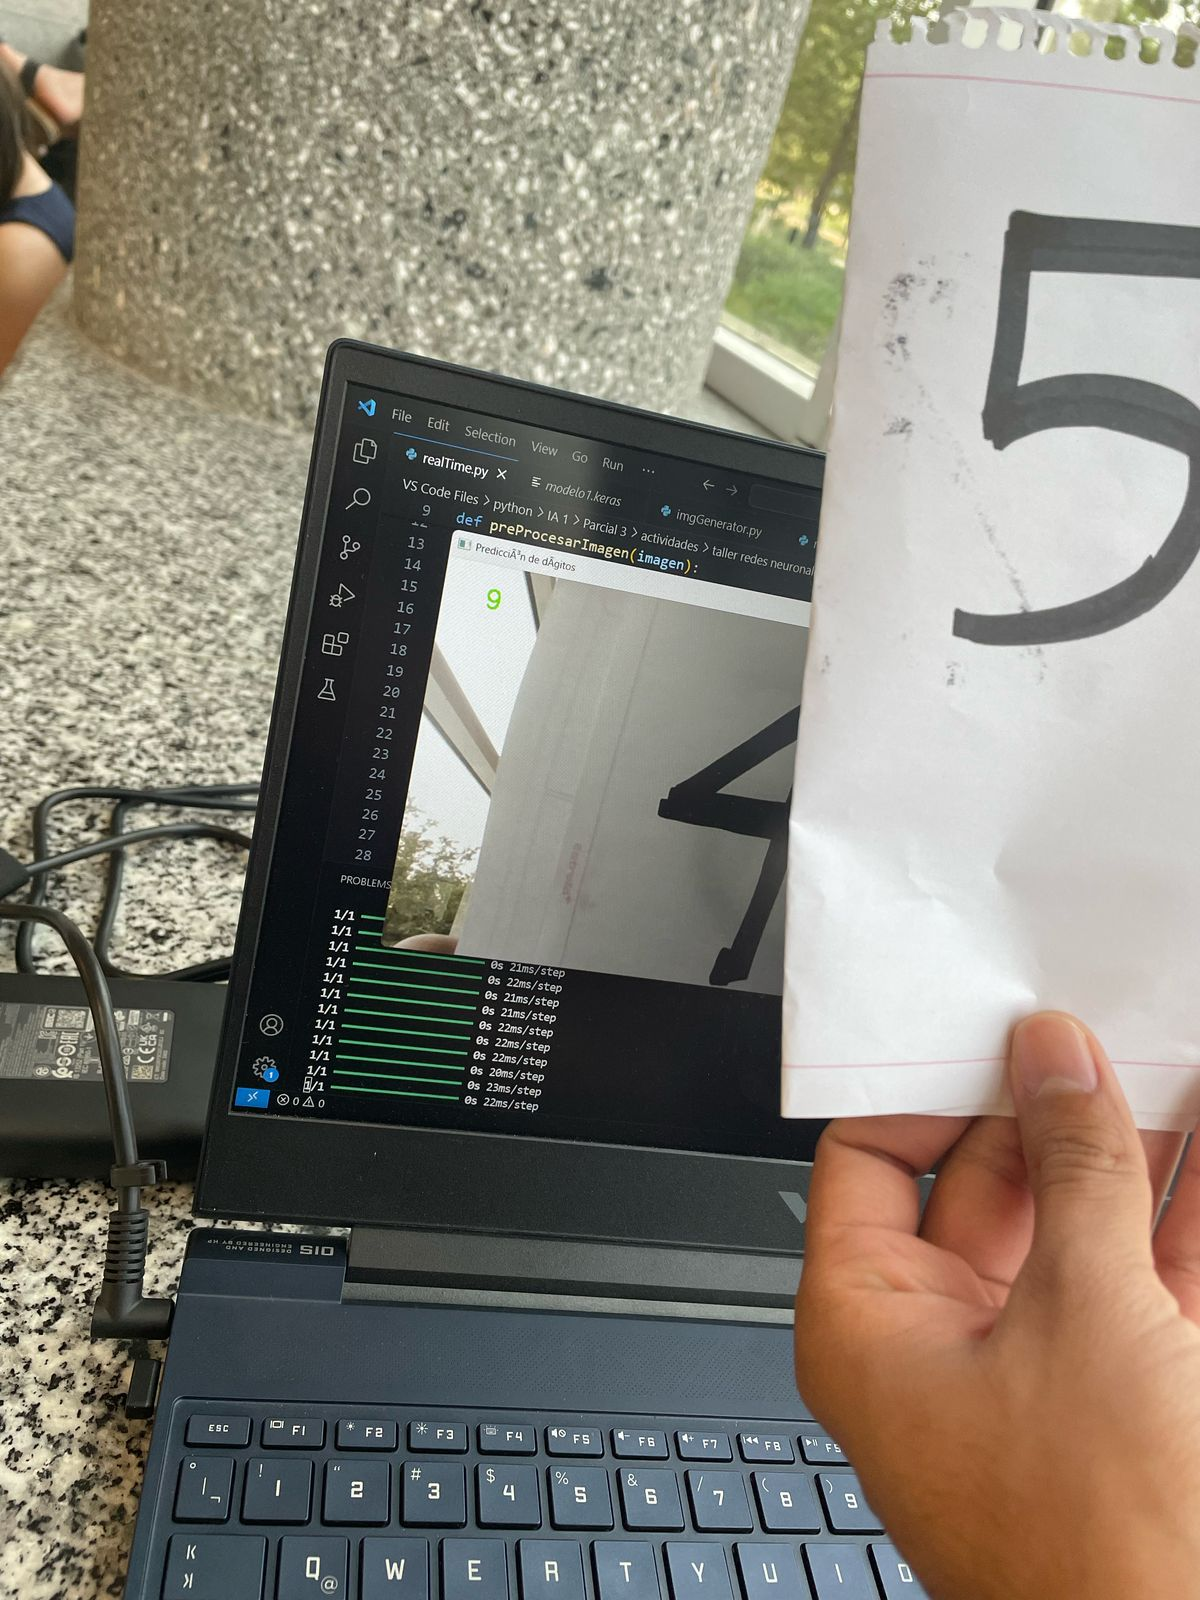

El 4 lo identificó correctamente, pero en estas dos imágenes de arriba no lo identificó. Por eso creo que se debió la pérdida de accuracy, y por eso usualmente se usan redes neuronales convolucinales para este tipo de tareas. Pero eso está fuera del alcance de este trabajo